In [1]:
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# 1. Data preparation

In [2]:
file_path = 'NS_adatok_cln.xlsx'
df = pd.read_excel(file_path)
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)

yield_cols = ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180']
maturities = [0.033, 1, 3, 6, 12, 36, 60, 120, 180]
maturities_years = np.array([0.033, 1, 3, 6, 12, 36, 60, 120, 180]) / 12
yields_data = df[yield_cols]


gdp_log = np.log(df['GDP'])
cycle, trend = sm.tsa.filters.hpfilter(gdp_log, lamb=1600)
df['Output_Gap'] = cycle * 100


df['Exchange_Rate_Chg'] = np.log(df['Árfolyam']).diff() * 100
df['Base_Rate'] = df['Kamat']
df['Inflation'] = df['Infláció']


# 2. PCA

In [3]:
pca = PCA(n_components=3)
pca.fit(yields_data)

explained_variance = pca.explained_variance_ratio_

print("\n=== PCA EREDMÉNYEK (Magyarázóerő) ===")
print(f"1. Komponens (Level):     {explained_variance[0]*100:.2f}%")
print(f"2. Komponens (Slope):     {explained_variance[1]*100:.2f}%")
print(f"3. Komponens (Curvature): {explained_variance[2]*100:.2f}%")
print("-" * 30)
print(f"Összesített magyarázóerő: {sum(explained_variance)*100:.2f}%")


=== PCA EREDMÉNYEK (Magyarázóerő) ===
1. Komponens (Level):     97.05%
2. Komponens (Slope):     2.65%
3. Komponens (Curvature): 0.22%
------------------------------
Összesített magyarázóerő: 99.92%


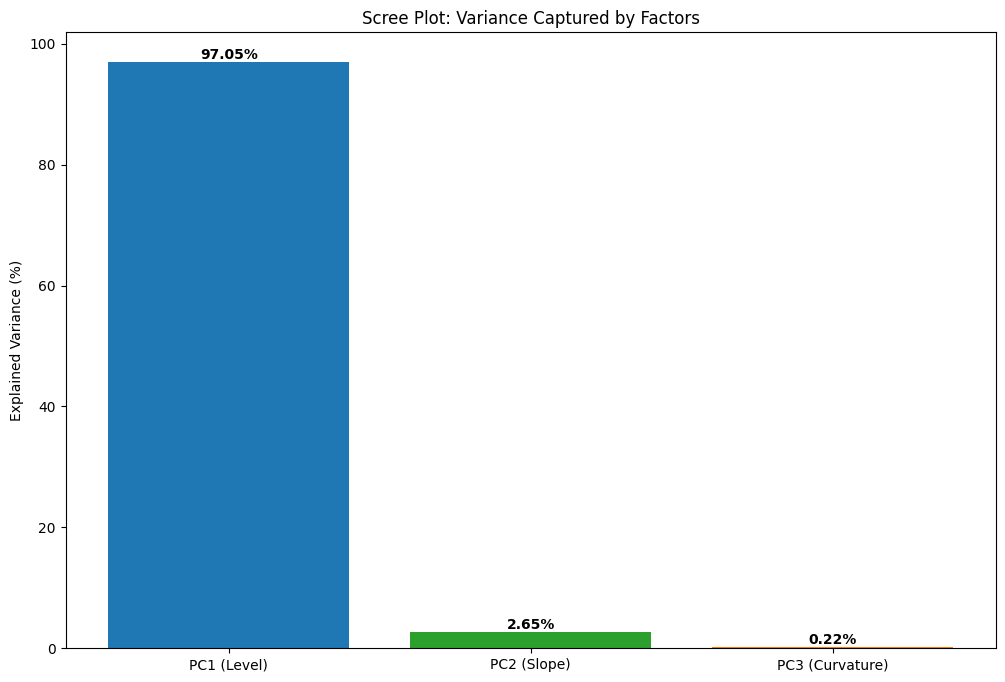

In [4]:
plt.figure(figsize=(12, 8))
components = ['PC1 (Level)', 'PC2 (Slope)', 'PC3 (Curvature)']
plt.bar(components, explained_variance * 100, color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.ylabel('Explained Variance (%)')
plt.title('Scree Plot: Variance Captured by Factors')

for i, v in enumerate(explained_variance):
    plt.text(i, v*100 + 0.5, f"{v*100:.2f}%", ha='center', fontweight='bold')

plt.show()

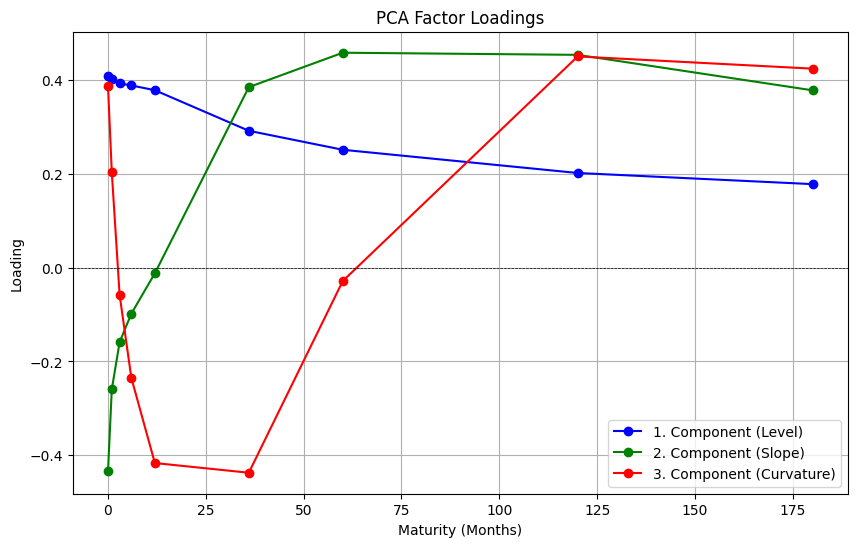

In [5]:
components = pca.components_

plt.figure(figsize=(10, 6))
plt.plot(maturities, components[0], marker='o', label='1. Component (Level)', color='blue')
plt.plot(maturities, components[1], marker='o', label='2. Component (Slope)', color='green')
plt.plot(maturities, components[2], marker='o', label='3. Component (Curvature)', color='red')

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('PCA Factor Loadings')
plt.xlabel('Maturity (Months)')
plt.ylabel('Loading')
plt.legend()
plt.grid(True)
plt.show()


pca_factors = pca.transform(yields_data)
pca_df = pd.DataFrame(pca_factors, columns=['Level_PCA', 'Slope_PCA', 'Curvature_PCA'], index=df.index)


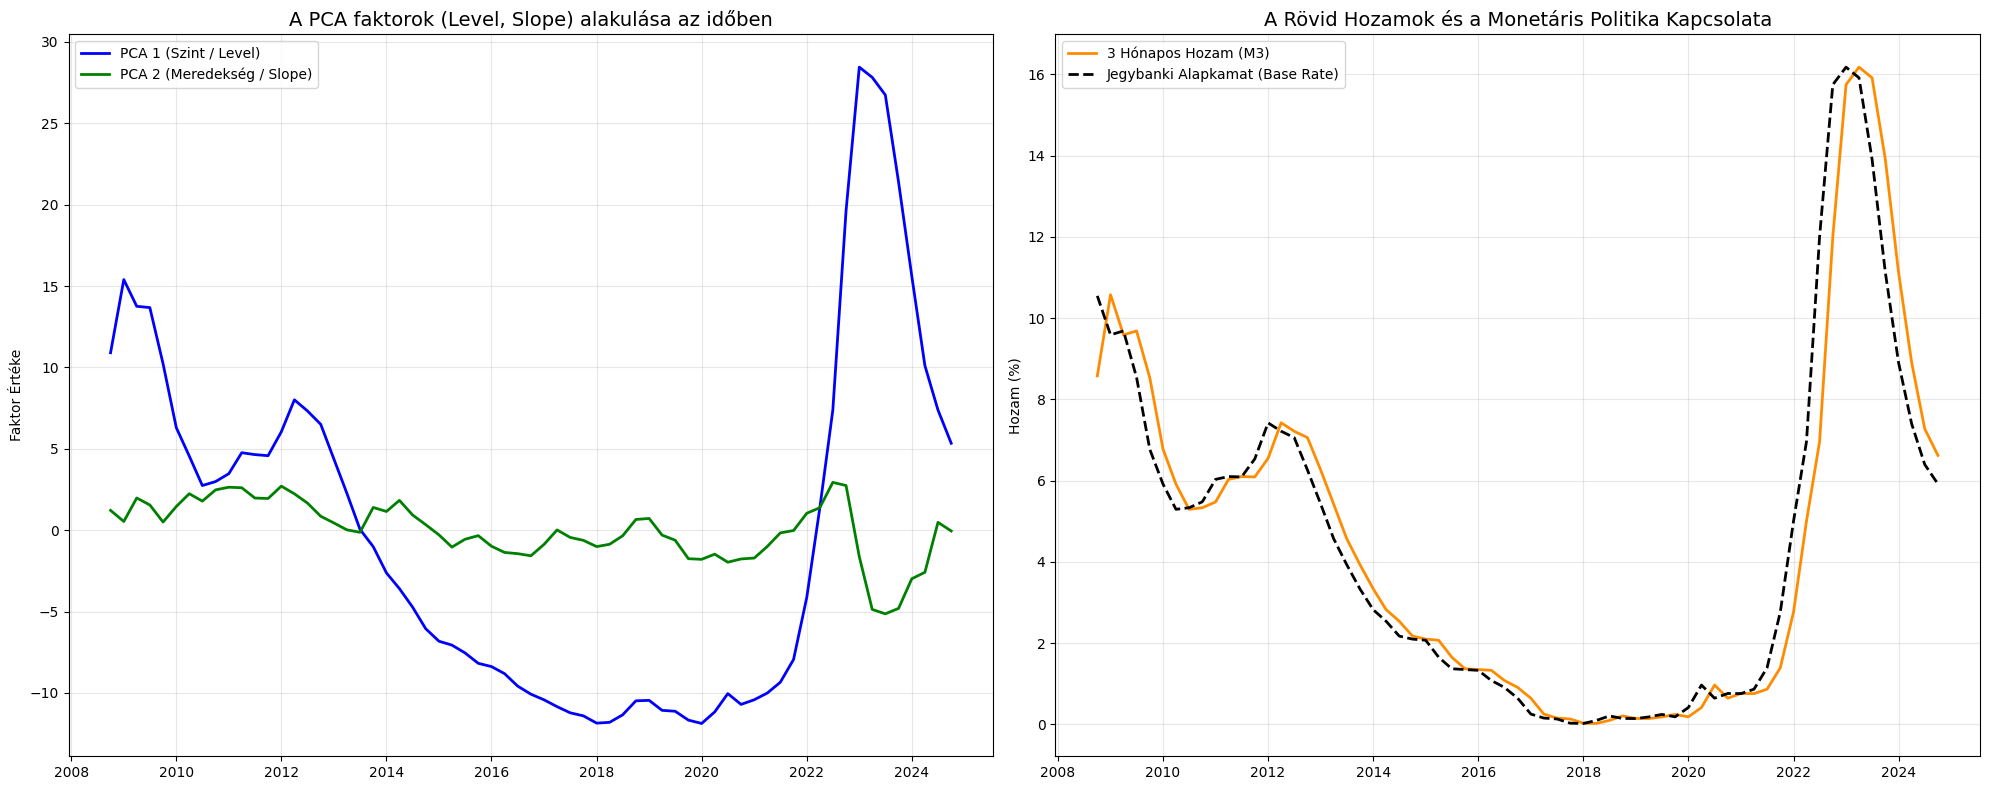

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].plot(pca_df['Level_PCA'], label='PCA 1 (Szint / Level)', color='blue', linewidth=2)
axes[0].plot(pca_df['Slope_PCA'], label='PCA 2 (Meredekség / Slope)', color='green', linewidth=2)

axes[0].set_title('A PCA faktorok (Level, Slope) alakulása az időben', fontsize=14)
axes[0].set_ylabel('Faktor Értéke')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df['M3'], label='3 Hónapos Hozam (M3)', color='darkorange', linewidth=2)
axes[1].plot(df.index, df['Kamat'], label='Jegybanki Alapkamat (Base Rate)', color='black', linestyle='--', linewidth=2)

axes[1].set_title('A Rövid Hozamok és a Monetáris Politika Kapcsolata', fontsize=14)
axes[1].set_ylabel('Hozam (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Lambda optimalizálása...
-> 2-faktoros Lambda: 0.5502
-> 3-faktoros Lambda: 0.6056


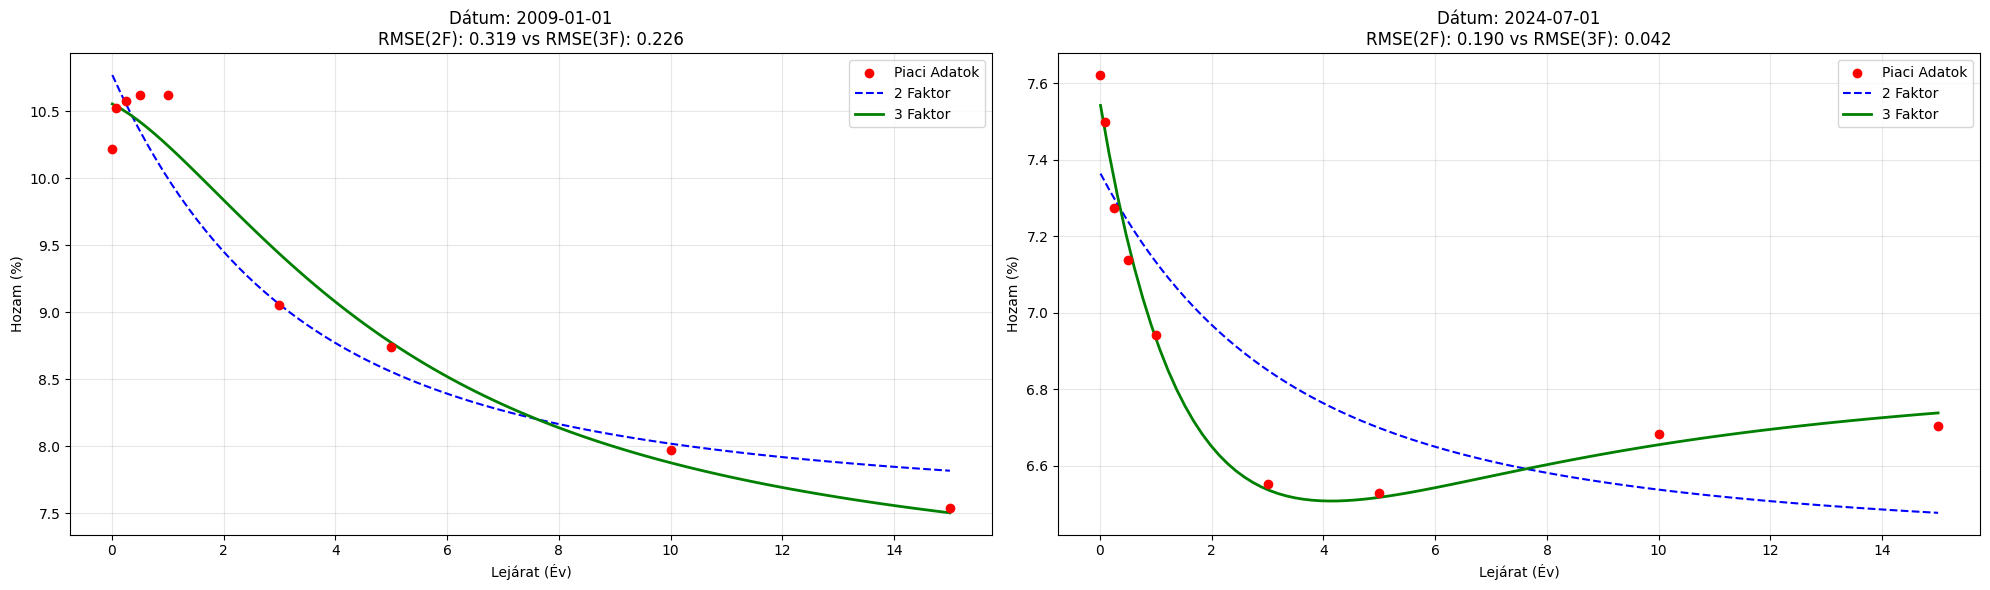

In [7]:
date1 = '2009-01-01'
date2 = '2024-07-01'

def ns_loadings_2factor(tau, lam):
    col_level = np.ones_like(tau)
    col_slope = (1 - np.exp(-lam * tau)) / (lam * tau)
    return np.column_stack((col_level, col_slope))

def ns_loadings_3factor(tau, lam):
    col_level = np.ones_like(tau)
    col_slope = (1 - np.exp(-lam * tau)) / (lam * tau)
    col_curv = col_slope - np.exp(-lam * tau)
    return np.column_stack((col_level, col_slope, col_curv))

def get_rmse_generic(lam, y_data, tau, model_func):
    if lam <= 0: return 1e10
    X = model_func(tau, lam)
    try:
        beta = np.linalg.pinv(X) @ y_data.values.T
        y_pred = (X @ beta).T
        return np.sqrt(np.mean((y_data.values - y_pred)**2))
    except:
        return 1e10

print("Lambda optimalizálása...")
res_2f = minimize(get_rmse_generic, x0=0.7, args=(yields_data, maturities_years, ns_loadings_2factor), method='Nelder-Mead')
opt_lambda_2f = res_2f.x[0]
res_3f = minimize(get_rmse_generic, x0=0.7, args=(yields_data, maturities_years, ns_loadings_3factor), method='Nelder-Mead')
opt_lambda_3f = res_3f.x[0]

print(f"-> 2-faktoros Lambda: {opt_lambda_2f:.4f}")
print(f"-> 3-faktoros Lambda: {opt_lambda_3f:.4f}")

def plot_ns_fit(ax, date, y_data_all, tau, lam2, lam3):
    if date not in y_data_all.index:
        date = y_data_all.index[0]

    actuals = y_data_all.loc[date].values

    X2 = ns_loadings_2factor(tau, lam2)
    reg2 = LinearRegression(fit_intercept=False).fit(X2, actuals)

    X3 = ns_loadings_3factor(tau, lam3)
    reg3 = LinearRegression(fit_intercept=False).fit(X3, actuals)

    tau_smooth = np.linspace(0.01, 15, 100)
    curve2 = reg2.predict(ns_loadings_2factor(tau_smooth, lam2))
    curve3 = reg3.predict(ns_loadings_3factor(tau_smooth, lam3))

    ax.scatter(tau, actuals, color='red', label='Piaci Adatok', zorder=5)
    ax.plot(tau_smooth, curve2, label=f'2 Faktor', color='blue', linestyle='--')
    ax.plot(tau_smooth, curve3, label=f'3 Faktor', color='green', linewidth=2)

    rmse2 = np.sqrt(np.mean((actuals - reg2.predict(X2))**2))
    rmse3 = np.sqrt(np.mean((actuals - reg3.predict(X3))**2))

    ax.set_title(f'Dátum: {str(date)[:10]}\nRMSE(2F): {rmse2:.3f} vs RMSE(3F): {rmse3:.3f}')
    ax.set_xlabel('Lejárat (Év)')
    ax.set_ylabel('Hozam (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
plot_ns_fit(axes[0], date1, yields_data, maturities_years, opt_lambda_2f, opt_lambda_3f)
plot_ns_fit(axes[1], date2, yields_data, maturities_years, opt_lambda_2f, opt_lambda_3f)

plt.tight_layout()
plt.show()


## STACIONARITÁS VIZSGÁLAT (ADF TESZT)

In [8]:
X_3f = ns_loadings_3factor(maturities_years, opt_lambda_3f)
ns_factors_3f = []

for index, row in yields_data.iterrows():
    reg = LinearRegression(fit_intercept=False).fit(X_3f, row.values)
    ns_factors_3f.append(reg.coef_)

ns_df_3f = pd.DataFrame(ns_factors_3f, columns=['Level_NS', 'Slope_NS', 'Curvature_NS'], index=df.index)
var_data_3f = pd.concat([
    ns_df_3f[['Level_NS', 'Slope_NS', 'Curvature_NS']],
    df[['Base_Rate', 'Inflation', 'Output_Gap', 'Exchange_Rate_Chg']]
], axis=1).dropna()

print("\n=== Stacionaritás Vizsgálat (ADF) a 3-Faktoros Modellel ===")
print(f"{'Változó':<20} {'ADF Stat':<10} {'p-érték':<10} {'Eredmény'}")
print("-" * 55)

for col in var_data_3f.columns:
    result = adfuller(var_data_3f[col])
    p_value = result[1]
    if p_value < 0.05:
        verdict = "Stacioner (OK)"
    else:
        verdict = "Nem stacioner (!)"
    print(f"{col:<20} {result[0]:<10.4f} {p_value:<10.4f} {verdict}")


=== Stacionaritás Vizsgálat (ADF) a 3-Faktoros Modellel ===
Változó              ADF Stat   p-érték    Eredmény
-------------------------------------------------------
Level_NS             -1.9703    0.2998     Nem stacioner (!)
Slope_NS             -1.3004    0.6290     Nem stacioner (!)
Curvature_NS         -3.0048    0.0344     Stacioner (OK)
Base_Rate            -1.2654    0.6449     Nem stacioner (!)
Inflation            -0.6489    0.8595     Nem stacioner (!)
Output_Gap           -5.1021    0.0000     Stacioner (OK)
Exchange_Rate_Chg    -6.6604    0.0000     Stacioner (OK)


In [30]:
from sklearn.preprocessing import StandardScaler
df = pd.read_excel('NS_adatok_cln.xlsx')
rename_dict = {
    'DATE': 'Date',
    'M0.033': 'M0.033',
    'M1': 'M1',
    'M3': 'M3',
    'M6': 'M6',
    'M12': 'M12',
    'M36': 'M36',
    'M60': 'M60',
    'M120': 'M120',
    'M180': 'M180',
    'Kamat': 'Base_Rate',
    'Árfolyam': 'Exchange_Rate',
    'GDP': 'GDP',
    'Végső fogyasztás': 'Final_Consumption',
    'Export': 'Export',
    'Kockázati prémium': 'Risk_Premium',
    'Külső kamat': 'External_Interest_Rate',
    'Privát foglalkoztatott': 'Private_Employment',
    'Teljes állami létszám': 'Total_Public_Employment',
    'Közmunkások': 'Public_Work_Participants',
    'Állami létszám közfoglalkoztatottak nélkül': 'Public_Employment_Excl_Public_Work',
    'Infláció': 'Inflation',
    'Importár': 'Import_Price',
    'Háztartások rendelkezésre álló jövedelme': 'Household_Disposable_Income',
    'Háztartások rendelkezésre álló jövedelme (2015)': 'Household_Disposable_Income_2015',
    'Háztartások megtakarítása': 'Household_Savings'
}
df.rename(columns=rename_dict, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

yield_cols = ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180']
maturities = np.array([0.033, 1, 3, 6, 12, 36, 60, 120, 180]) / 12.0
lam_fixed = 0.7308

lambda_2f = 0.7308
lambda_3f = 0.7308

data_clean = df[yield_cols].copy()
data_clean['Base_Rate'] = df['Base_Rate']
data_clean['Inflation'] = df['Inflation']
data_clean['GDP_Growth'] = df['GDP'].pct_change() * 100
data_clean['FX_Change'] = df['Exchange_Rate'].pct_change() * 100
data_clean = data_clean.dropna()

scaler = StandardScaler()
macro_cols = ['Base_Rate', 'Inflation', 'GDP_Growth', 'FX_Change']
data_clean[macro_cols] = scaler.fit_transform(data_clean[macro_cols])

In [31]:
from scipy.optimize import minimize_scalar

def find_optimal_lambda(yield_df, maturities, n_factors=3):

    def objective_function(lam):
        if lam <= 0: return 1e10

        # 1. Loadings kiszámítása az adott lambdával
        l1 = np.ones_like(maturities)
        l2 = (1 - np.exp(-lam * maturities)) / (lam * maturities)

        if n_factors == 3:
            l3 = l2 - np.exp(-lam * maturities)
            L = np.column_stack([l1, l2, l3])
        else:
            L = np.column_stack([l1, l2])

        # 2. OLS becslés minden időpontra (mátrixosított forma a sebességért)
        # B = (L'L)^-1 * L' * Y'
        Y = yield_df.values.T  # (n_maturities, n_observations)
        try:
            # Pszeudo-inverz használata a faktorok gyors kinyeréséhez
            betas = np.linalg.pinv(L) @ Y

            # 3. Rekonstruált hozamok és hiba (RMSE)
            fitted = (L @ betas).T
            rmse = np.sqrt(np.mean((yield_df.values - fitted)**2))
            return rmse
        except np.linalg.LinAlgError:
            return 1e10

    # Optimalizálás: Keressük a lambdát a [0.1, 2.5] tartományban
    # Éves maturities esetén a lambda általában 0.5 és 1.5 között mozog
    res = minimize_scalar(objective_function, bounds=(0.01, 2.5), method='bounded')

    return res.x, res.fun

# --- FUTTATÁS ---

print("Lambda optimalizálása folyamatban...")

# 3-faktoros optimalizálás
opt_lambda_3f, min_rmse_3f = find_optimal_lambda(data_clean[yield_cols], maturities, n_factors=3)

# 2-faktoros optimalizálás
opt_lambda_2f, min_rmse_2f = find_optimal_lambda(data_clean[yield_cols], maturities, n_factors=2)

print(f"\n--- Eredmények ---")
print(f"3-Faktoros Modell: Optimális Lambda = {opt_lambda_3f:.6f} (RMSE: {min_rmse_3f:.6f})")
print(f"2-Faktoros Modell: Optimális Lambda = {opt_lambda_2f:.6f} (RMSE: {min_rmse_2f:.6f})")

# Most már frissítheted a korábbi kódod elején a változókat:
# lambda_3f = opt_lambda_3f
# lambda_2f = opt_lambda_2f

Lambda optimalizálása folyamatban...

--- Eredmények ---
3-Faktoros Modell: Optimális Lambda = 0.602879 (RMSE: 0.190265)
2-Faktoros Modell: Optimális Lambda = 0.553120 (RMSE: 0.331770)
